# Interpretable Machine Leaning with Python
Adapted from [this tutorial](http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html#PDP-and-ICE-plots) by Savvas Tjortjoglou <br>

In this tutorial, you will:
1. Train a Random Forest Regression model on data about football players
2. Learn about Mean Decrease Impurity, Mean Decrease Accuracy  importance, and how to apply them to the model
3. Learn how to evaluate and interpret feature contributions globally, and for single instances (decision paths), and various methods to visualize contributions

## 1. Train a Random Forest Regression Model

Steps: <br>
A. Create a conda environment with the packages we need (for whole tutorial) <br>
B. Import packages (for whole tutorial)<br>
C. Load in and subset the data we want to use in our model <br>
D. Split training and testing data <br>
E. Build the model <br>
F. Tune model parameters and train <br>
G. Apply model to test data and evaluate <br>

### A. Create conda Environment

In [25]:
#### Install in conda environment
# conda install -c conda-forge -c ets skll
# conda install -c conda-forge scikit-optimize
# conda install -c conda-forge tqdm 
# conda install -c conda-forge eli5
# conda install -c conda-forge graphviz 
# conda install -c conda-forge pydotplus
# pip install treeinterpreter
# pip install pycebox
# conda install -c conda-forge pdpbox 
# conda install -c conda-forge xgboost <-- failed for Shinhan, worked for Serena 
# pip install xgboost <-- failed for Serena, worked for Shinhan
# conda install -c conda-forge lime 
# conda install -c conda-forge shap

### B. Import packages

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [27]:
from sklearn.impute import SimpleImputer # this package is called scikit-learn
from sklearn.model_selection import  cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

In [28]:
from skopt import BayesSearchCV # this package is called scikit-optimize
from skopt.space import Real, Categorical, Integer

In [29]:
# set up the aesthetic for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(8,6)})

### C. Load in and subset data

In this tutorial, we're trying to predict the 'Approximate Value' (AV) of football players: an explanation can be found [here](https://www.pro-football-reference.com/about/glossary.htm). We are doing this using a dataset where instances are individual players, and there are various performance metrics for each player, which we will later use as features in our model.

In [30]:
# read in the data: modify path if data isn't in currend working directory
data_df = pd.read_csv('combine_data_since_2000_PROCESSED_2018-04-26.csv')

# make a subset of players that have been in the league for 3+ years, we will use this for our model
data_df2 = data_df.loc[data_df.Year <= 2015].copy()
data_df2.head()

,Player,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,Pfr_ID,AV,Team,Round,Pick
0,John Abraham,OLB,76,252,4.55,NaN,NaN,NaN,NaN,NaN,2000,AbraJo00,26.0,New York Jets,1.0,13.0
1,Shaun Alexander,RB,72,218,4.58,NaN,NaN,NaN,NaN,NaN,2000,AlexSh00,26.0,Seattle Seahawks,1.0,19.0
2,Darnell Alford,OT,76,334,5.56,25.0,23.0,94.0,8.48,4.98,2000,AlfoDa20,0.0,Kansas City Chiefs,6.0,188.0
3,Kyle Allamon,TE,74,253,4.97,29.0,NaN,104.0,7.29,4.49,2000,NaN,0.0,NaN,NaN,NaN
4,Rashard Anderson,CB,74,206,4.55,34.0,NaN,123.0,7.18,4.15,2000,AndeRa21,6.0,Carolina Panthers,1.0,23.0


In [31]:
# calculate the player AV percentiles by position
data_df2['AV_pctile'] = (data_df2.groupby('Pos').AV.rank(pct=True,
                                                         method='min', 
                                                         ascending=True))
data_df2.head()

,Player,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,Pfr_ID,AV,Team,Round,Pick,AV_pctile
0,John Abraham,OLB,76,252,4.55,NaN,NaN,NaN,NaN,NaN,2000,AbraJo00,26.0,New York Jets,1.0,13.0,0.951482
1,Shaun Alexander,RB,72,218,4.58,NaN,NaN,NaN,NaN,NaN,2000,AlexSh00,26.0,Seattle Seahawks,1.0,19.0,0.936123
2,Darnell Alford,OT,76,334,5.56,25.0,23.0,94.0,8.48,4.98,2000,AlfoDa20,0.0,Kansas City Chiefs,6.0,188.0,0.002611
3,Kyle Allamon,TE,74,253,4.97,29.0,NaN,104.0,7.29,4.49,2000,NaN,0.0,NaN,NaN,NaN,0.003509
4,Rashard Anderson,CB,74,206,4.55,34.0,NaN,123.0,7.18,4.15,2000,AndeRa21,6.0,Carolina Panthers,1.0,23.0,0.630058


In [32]:
# Get the data for the football position we want, in this case it's DE 
pos_df = data_df2.loc[data_df2.Pos=='DE'].copy().reset_index(drop=True)
pos_df.head()

,Player,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year,Pfr_ID,AV,Team,Round,Pick,AV_pctile
0,Michael Boireau,DE,76,274,5.09,29.0,26.0,105.0,7.68,4.49,2000,NaN,0.0,NaN,NaN,NaN,0.002427
1,Courtney Brown,DE,77,269,4.78,NaN,NaN,NaN,NaN,NaN,2000,BrowCo22,16.0,Cleveland Browns,1.0,1.0,0.871359
2,Lamont Bryant,DE,75,260,4.91,NaN,17.0,NaN,NaN,NaN,2000,BryaLa00,0.0,NaN,NaN,NaN,0.002427
3,Leonardo Carson,DE,73,283,5.06,28.0,22.0,106.0,7.82,4.75,2000,CarsLe20,10.0,San Diego Chargers,4.0,113.0,0.730583
4,Rameel Connor,DE,75,276,5.00,35.5,25.0,121.0,7.65,4.45,2000,NaN,0.0,NaN,NaN,NaN,0.002427


### D. Split testing and training data

In [33]:
# Split the data into train and test sets
train_df = pos_df.loc[pos_df.Year <= 2011]
test_df  = pos_df.loc[pos_df.Year.isin([2012, 2013, 2014, 2015])]

### E. Build the model

In [34]:
# Get list of feature names
features = ['Forty', 'Wt', 'Ht', 'Vertical', 'BenchReps', 'BroadJump', 'Cone', 'Shuttle']
# define what we want to predict (label)
target   = 'AV_pctile'

# separate feature (X) and label (y) values from training set
X = train_df[features].values
y = train_df[target].values

In [35]:
# What do X and y look like?
print("Feature values: {}".format(X[:5,:])) # this is a numpy array
print("Label values: {}".format(y[:5])) # this is a list

Feature values: [[  5.09 274.    76.    29.    26.   105.     7.68   4.49]
 [  4.78 269.    77.      nan    nan    nan    nan    nan]
 [  4.91 260.    75.      nan  17.      nan    nan    nan]
 [  5.06 283.    73.    28.    22.   106.     7.82   4.75]
 [  5.   276.    75.    35.5   25.   121.     7.65   4.45]]
Label values: [0.00242718 0.87135922 0.00242718 0.73058252 0.00242718]


--------------
In this tutorial we're going to use scikit-learn's `Pipeline` object.

`Pipeline` is a method that combines a customizable number of steps in a machine learning pipeline into one. [This paper](https://arxiv.org/pdf/1309.0238.pdf) on scikit-learn's API has a good explanation of what `Pipeline` is, on page 8-9. A brief explanation with definitions (quotes are from the API paper):

*Definitions (from the scikit-learn glossary):* <br>

**estimator**:<br>
An object which manages the estimation and decoding of a model. The model is estimated as a deterministic function of:
- parameters provided in object construction or with set_params;
- the global numpy.random random state if the estimator’s random_state parameter is set to None; and
- any data or sample properties passed to the most recent call to fit, fit_transform or fit_predict, or data similarly passed in a sequence of calls to partial_fit.

The estimated model is stored in public and private attributes on the estimator instance, facilitating decoding through prediction and transformation methods. <br>

Estimators must provide a fit method, and should provide set_params and get_params, although these are usually provided by inheritance from base.BaseEstimator. <br>

The core functionality of some estimators may also be available as a function. <br>

**predictor**:<br>
An estimator supporting predict and/or fit_predict. This encompasses classifier, regressor, outlier detector and clusterer.

In statistics, “predictors” refers to features.

**transformer**: <br>
An estimator supporting transform and/or fit_transform. A purely transductive transformer, such as manifold.TSNE, may not implement transform.

(Note: This is *not* the NLP deep learning method Transformer that works on sequence transduction. See post [here](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65))<br>

An **imputer** is not in the glossary, but generally an imputer is anything that infers missing values from the data. 


*Explanation:*<br>
`Pipeline` chains multiple estimators (transformers and predictors) together. "A sequence of N such
steps can be combined into a Pipeline if the first N − 1 steps are transformers;
the last can be either a predictor, a transformer or both."<br>

In other words, `Pipeline` is used to combine multiple steps in a machine learning pipeline into one, and this does not have to include the model itself; it can be used to pre-process data. The `Pipeline` acts as whatever its last step is. "The pipeline exposes all the
methods the last estimator in the pipe exposes. That is, if the last estimator is
a predictor, the pipeline can itself be used as a predictor. If the last estimator is
a transformer, then the pipeline is itself a transformer."

In this example, we're using the `Pipeline` object to encompass our imputer (used to impute the nan's we saw in the training data) and our predictor (the Random Forest Regression model).

In [36]:
# make our pipeline for this model

# Since we're using RF, need to define our random state
# the RANDOM_STATE parameter for RF models is (from the scikit-optimize docs):
# Pseudo random number generator state used for random uniform sampling from lists
# of possible values instead of scipy.stats distributions
RANDOM_STATE = 420 
pipe = Pipeline([("imputer", SimpleImputer()), 
                 ("estimator", RandomForestRegressor(random_state=RANDOM_STATE))])

### E. Tune model parameters and train

The **parameters** of a machine learning model are internal to the model, and optimal values are learned during the training process. However, machine learning models also have **hyperparameters**, or, parameters that are important to the model's performance, but can't be learned from the data (for example, how many trees should be in our random forest?). In order to choose the optimal hyperparameters, we can perform one of several methods.

**Grid Search**: Test every possible combination of hyperparameters. This is very intensive for most models.<br>
**Random Search**: Randomly choose hyperparameters from a distribution. Has better and faster performance than Grid Search. Explanation of why random search is better can be found [here](https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881)<br>
**Bayes Search**: Uses Bayesian optimization to search for hyperparameters. Better and faster than both the above methods. A detailed explanation can be found [here](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a)<br>

In this example, we'll use the `BayesSearchCV` method from scikit-optimize (Docs [here](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV
)).

In [37]:
# first, define the parameter space over which to search 
rf_param_space = {
    'imputer__strategy': Categorical(['mean', 'median', 'most_frequent']),
    'estimator__max_features': Integer(1, 8),
    'estimator__n_estimators': Integer(50, 500), 
    'estimator__min_samples_split': Integer(2, 200),
}

In [38]:
# next, we define a scoring function that will be used to evaluate the performance of the model with 
# various hyperparameters. r2 is Pearson's correlation coefficient.
from sklearn.metrics import r2_score  
r2 = make_scorer(r2_score)

#### A note about make_scorer:
From the docs:<br>
You can generate even more flexible model scorers by constructing your own scoring object from scratch, without using the make_scorer factory. For a callable to be a scorer, it needs to meet the protocol specified by the following two rules:
1. It can be called with parameters (estimator, X, y), where estimator is the model that should be evaluated, X is validation data, and y is the ground truth target for X (in the supervised case) or None (in the unsupervised case).
2. It returns a floating point number that quantifies the estimator prediction quality on X, with reference to y. Again, by convention higher numbers are better, so if your scorer returns loss, that value should be negated.

This is why, when we call r2 later on, we call it as: 

    r2(search, X, y)

In [39]:
# create our Bayes search object using the Sklearn-Optimize package

N_JOBS=8

search = BayesSearchCV(pipe,                      # Estimator
                       rf_param_space,            # Search_space
                       cv=10,                     # Cross-validation generator or an iterable
                       n_jobs=N_JOBS,             # Number of job run in parallel 
                       verbose=0, 
                       error_score=-9999,         # Value to assign to the score if an error occurs in estimator fitting.
                       scoring=r2,                # Loss function
                       random_state=RANDOM_STATE, # For random uniform sampling
                       return_train_score=True,   # The cv_results_ attribute will include training scores.
                       n_iter=10)                 # Number of parameter settings that are sampled.

# n_iter is set very low in order to run the whole thing faster, would nnormally use much higher number.

What is the output of `BayesSearchCV( )`? i.e., what is in our object `search`? <br>

*Attributes:* <br>
**cv_results_**: dict of numpy (masked) ndarrays <br>
A dict with keys as column headers and values as columns, that can be imported into a pandas DataFrame. <br>

**best_estimator_**: estimator <br>
Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data. Not available if refit=False. <br>

**best_score_** : float <br>
Score of best_estimator_ on the left out data.<br>

**best_params_**: dict <br>
Parameter setting that gave the best results on the hold out data. <br>

**best_index_**: int <br>
The index (of the `cv_results_` arrays) which corresponds to the best candidate parameter setting. <br>

The dict at `search.cv_results_['params'][search.best_index_]` gives the parameter setting for the best model, that gives the highest mean score (`search.best_score_`). <br>

**scorer_**: function <br>
Scorer function used on the held out data to choose the best parameters for the model. <br>

**n_splits_**: int <br>
The number of cross-validation splits (folds/iterations).<br>

Class methods used in this tutorial: 
1. `fit(self,X,y,groups,callback)` : Run fit on the estimator with randomly drawn parameters. Only X and y are required, can provide group labels used while splitting the dataset into train/test. 
2. `predict(self,X)` : Call predict on the estimator with the best found parameters --> predicts labels/values for the provided instances.

In [40]:
# fit (train) the model 
# need to train the model before any of the following steps can be performed
search.fit(X, y)

BayesSearchCV(cv=10, error_score=-9999,
              estimator=Pipeline(memory=None,
                                 steps=[('imputer',
                                         SimpleImputer(add_indicator=False,
                                                       copy=True,
                                                       fill_value=None,
                                                       missing_values=nan,
                                                       strategy='mean',
                                                       verbose=0)),
                                        ('estimator',
                                         RandomForestRegressor(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               criterion='mse',
                                                               max_depth=None,
                                                               

In [41]:
# view best model parameters 
search.best_params_

OrderedDict([('estimator__max_features', 6),
             ('estimator__min_samples_split', 42),
             ('estimator__n_estimators', 375),
             ('imputer__strategy', 'most_frequent')])

In [42]:
# view score of best_estimator on the left out data (i.e. how did the model perform?)
# this is the score using the performance metric (scorer) that we provided to BayesSearchCV( ), here is r2
search.best_score_

0.1251275916733097

**NOTE TO SELF** need to figure out what the "left out" data is, is this the best score of the cross validation splits, when the model is applied to the 10% that was left out (but that the model has already seen)?

In [43]:
# View scores for training and testing of cross-validation splits 
searchResults = pd.DataFrame(search.cv_results_)
searchResults.head()

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,...,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_features,param_estimator__min_samples_split,param_estimator__n_estimators,param_imputer__strategy,params,rank_train_score
0,-0.054400,0.102235,0.101677,0.034888,0.054914,0.031297,0.135804,0.085493,0.092222,0.111375,...,1.585020,0.535479,0.080290,0.030482,5,142,287,median,"{'estimator__max_features': 5, 'estimator__min...",8
1,-0.075334,0.181726,0.202825,0.058129,0.092091,0.000007,0.195300,0.134274,0.144350,0.158326,...,0.712002,0.197974,0.031392,0.013054,7,93,137,mean,"{'estimator__max_features': 7, 'estimator__min...",5
2,-0.059033,0.124095,0.165521,0.064966,0.095709,-0.004723,0.130411,0.130675,0.116789,0.122949,...,1.151458,0.335561,0.049212,0.017882,7,117,231,most_frequent,"{'estimator__max_features': 7, 'estimator__min...",6
3,-0.060937,0.233634,0.284892,0.048825,0.094346,-0.006292,0.241879,0.111467,0.132016,0.176489,...,2.058423,0.607050,0.085776,0.030330,6,42,375,most_frequent,"{'estimator__max_features': 6, 'estimator__min...",1
4,-0.057614,0.110046,0.130069,0.048667,0.067302,0.022258,0.151105,0.092738,0.092853,0.114085,...,1.078048,0.351547,0.057439,0.020748,5,132,217,median,"{'estimator__max_features': 5, 'estimator__min...",7


In [44]:
# now apply the model to the test data

# define test set data
X_test = test_df[features].values
y_test = test_df[target].values

# apply the model
y_pred = search.predict(X_test)

# evaluate performance on test data
model_test_score = r2(search, X_test, y_test) 
model_test_score # why is this negative? Does this mean the model is really bad? Why is it so much worse on the test data?

-0.031092927334830156

In [45]:
# test the correlation between ground truth and predicted values with pearson correlation coefficient (PCC)
from scipy.stats import pearsonr
pearsonr(y_test, y_pred) # returns (r, two-tailed p-value)

(0.23099783203501978, 0.02355094844797427)

**NOTE TO SELF**: why is this such a better score than r2? Shouldn't r2 be the same exact thing??

## 2. Learn About Feature Importance Measures

In this section you will learn about: <br>
A. Gini impurity, and its regression counterpart <br>
B. Mean Decrease Impurity, how it's calculated using A, and how to get it for our model. <br>
C. Mean Decrease Accuracy, also known as Permutation Importance <br>
D. Pros and cons of each method

### A. Gini Impurity and Mean Square Error

#### Gini Impurity
Gini impurity is a measure of how good a given split is in a classification tree. First, let's review how classification trees work.

We start with the whole dataset. Each *instance* has some data associated with it; these data fall into groups called *features*. Each instance also has a *label* associated with it; this label represents the group to whcih the instance belongs. A classification tree aims to split the data in such a way that at the end, we have a separate group for each type of label. This splitting is done by using the information we have about each instance: the features. Consider the following example:

![A decision tree that gives the reccomendation to go or not go to the store.](img/Classification.png)

Our original dataset is hours of the day, during one week. The features associated with each hour are, Out Of Food?, Raining?, and Hungry?. By splitting the data based on what value they have for a certain feature, we can decide if an hour belongs to the category where we should go to the store, or not go to the store. The same logic applies if we're trying to classify things into categories.

So what does Gini impurity have to do with all this? Well, imagine that we're training a model to classify things using a decision tree. We could use different features at different nodes (these are called splits), and it would give us vastly different outcomes. Some versions of the tree are clearly better than others, because depending on which features we put where, we might mis-classify many instances. But what if we have lots of features, and it isn't intuitive which set of splits is better than another. 

Using the following figure, let's walk through a simple explanation of Gini impurity, adapted from [this post](https://victorzhou.com/blog/gini-impurity/).

![A classification decision tree. 7 of 10 datapoints have arrived at node j, 5 red and 2 purple. The daughter nodes perfectly split the data, so one has 5 red dots and the other has 2 purple. 3 red dots are at the suster node to node j](img/Gini.png)

Gini impurity is calculated for each split (also called a node). Imagine we want to calculate the Gini impurity of node $n_{j}$. The dots around each node represent the data points (instances) that have arrived to that node by following the previous splits in the tree. Here, purple and red represent the two different classes we're trying to classify. Our simple explanation is the following: for each split,

1. Randomly pick a point within the split 
2. Randomly classify it according to the class distribution within that split (e.g. if there are 10 points, 5 from Class A and 5 from Class B, half the time we’d classify it as A, the other half B)
3. Determine the probability that we classify the datapoint incorrectly. This is the Gini Impurity. 


This process is summarized in the following table for our example. First, we determine the probability each even occuring: choosing a point of that color (Step 1), and then classifying it correctly or incorrectly (Step 2). 

| Event | Classification| Math| Probability   |
|:------:|:------:|:------:|:-----:|
| Pick red, classify red | Correct|  $\frac{5}{7}$ \* $\frac{5}{7}$| 0.51|
| Pick red, classify purple | Incorrect| $\frac{5}{7}$ \* $\frac{2}{7}$| 0.20 |
| Pick purple, classify purple | Correct| $\frac{2}{7}$ \* $\frac{2}{7}$| 0.08 |
| Pick purple, classify red | Incorrect | $\frac{2}{7}$ \* $\frac{5}{7}$| 0.20 |

Then, we take the event probabilities for the incorrect classifications and add them together to get the Gini impurity (Step 3). 

$$\textrm{Gini impurity for } n_{j} = 0.20+0.20=0.40$$

That was possible for a simple example, but what about more complicated ones? Now let's talk about the mathematical definition of Gini impurity. <br>

**Definition**: $$\sum\limits_{i=1}^C p(i)(1-p(i))$$

where $p(i)$ is the probability of picking a datapoint with class $i$, and $C$ is the total number of classes. 



If we use our example above with this formula: 

$$p(red)(1-p(red)) + p(purple)(1-p(purple))$$
$$\frac{5}{7}(1-\frac{5}{7})) + \frac{2}{7}(1-\frac{2}{7}))$$
$$0.20+0.20$$
$$0.40$$

As you can see, we get the same result with this formula!

Intuitively, what is Gini impurity? It's the probability of classifying something incorrectly at a given node. So the lower the impurity, the better we are at making predictions at that node.

#### Impurity for regressions
As you can see, this method only works if we are working with a classification problem. What about regressions?

First, let's review how regression trees work. This section is adapted from [this absolutely wonderful lecture](http://www.stat.cmu.edu/~cshalizi/350-2006/lecture-10.pdf). <br>

In a linear regression, we fit one model (predictive formula) over the entire data-space. However, if the data has lots of features which interact in complicated, nonlinear ways, it’s very difficult to fit a good linear model, and because of all the terms you would have to add to the equation in order to get a fit over the whole data space, the resulting model is extraordinarily complicated and uninterpretable. <br>

Therefore, we can do something called recursive partitioning. Instead of fitting a global model, we can subdivide, or partition, the dataspace into smaller regions. We continue splitting these partitions (which is why it’s called recursive partitioning) until we have manageable chunks of data-space where we can fit simple models. The division of the dataspace is done by features, the same as for a classification tree. <br>

Regression trees are a way of representing recursive partitioning. Each of the terminal leaves of the tree represents a final partition, which has attached to it a simple model, as illustrated below. <br>

![A regression decision tree for predicting car prices based on horesepower and wheelbase. Each edge contains an inequality indicating the value that feature was split on; for example, if the horsepower was split at 1.3, the two edges would have the inequalities "less than 1.3" and "greater than 1.3". The leaves (terminal nodes) have the predicted price, and in parenthesis the number of instances arrived at that leaf. The internal nodes have the name of the feature on which the node was split. The caption reads:  Regression tree for predicting price of 1993-model cars. All features
have been standardized to have zero mean and unit variance. Note that the order
in which variables are examined depends on the answers to previous questions.
The numbers in parentheses at the leaves indicate how many cases (data points)
belong to each leaf.](img/regression.png)

In the above, the word at each node is the feature on which the data is being split. These are continuous features, and the partition is made by choosing a value of that feature at which to split the data. As you can see, Horsepower shows up three times, and each time, a different value is used to make the split.You can get a more intuitive sense of this by looking at the following figure: <br>

![A 2 dimensional scatter plot with vertical and horizontal lines partitioning the data. Within each partition is the mean for the quantity of interest of the points within the partition. The caption for the figure reads: The partition of the data implied by the regression tree from Figure 1.
Notice that all the dividing lines are parallel to the axes, because each internal
node checks whether a single variable is above or below a given value.](img/Partitions.png)

When there are more than two features, we are looking for partitions ina higher dimensional space. <br>

What are the simple local models? In a classic regression tree, this is just the sample mean of the dependent variable (from the training data) within the given partition. In the decision tree this is represented as "Price = (some number)", and in the partition figure, it is the number in red within each partition. This means a classic regression tree is a piecewise-constant model. Since this is easy to calculate once a tree is decided upon, all effort should go into finding the best set of partitions. <br>




Now that we're familiar with how splits are made in a regression tree, let's talk about the regression version of Gini impurity. It's actually much simpler: it's just Mean Square Error (MSE). This explanation is adapted from [this post](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3) on how feature importances are implemented in scikit-learn. <br>

**Definition**:

$$\frac{1}{N} \sum\limits_{i=1}^N (y_{i} - \mu)^2$$

Where $y_{i}$ is the label for an instance (its value), $N$ is the number of instances and $\mu$ is the mean given by $\frac{1}{N} \sum\limits_{i=1}^N y_{i}$. In plain english, MSE is the mean of the squared differences (error) between the true value (instance label) and the group mean at the node ($\mu$), for all instances at the node.

Let's work through a simple example, using the following tree: 

![A decision tree where 7 of 10 instances have arrived at node j, the numbers are 1, 3, 4, 5, 8, 9, and the daughter nodes contain 1, 3, 4, and 5, 8, 9, respectively.](img/MSE.png)

In order to calculate the MSE of $n_{j}$, we first have to calculate $\mu$ at $n_{j}$. 

$$\mu = \frac{1+3+4+5+8+9}{6} = 5$$

Then, we follow the formula:

$$\frac{1}{6}*((1-5)^2 + (3-5)^2 + (4-5)^2 + (5-5)^2 + (8-5)^2 + (9-5)^2) = 7.67$$

What does MSE mean intuitively, after we've worked through the above example? We could say that, at the end of a regression tree, predictions are made using the mean of all instances at the node. Therefore, the difference between a given instance label and the mean at the node is the error, because that’s how far off the prediction for that instance could be. 

### B. Mean Decrease Impurity
We can calculate impurity at nodes now, but so what? How can we use this to evalulate how good our tree is (and later on, our Random Forest model) at classification or regression? We can use Gini impurity and MSE to define something called Mean Decrease Impurity (MDI), which tells us how good a given feature is at helping to classify the data. MDI follows the same procedure for both classification and regression, and just uses different impurity measures.

#### The algorithm

A short description of how this is implemented in scikit-learn (from the same source above):<br>
“Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.”  <br>

What on earth does that mean? Let's break it down into steps. <br>

**1. Calculate the importance of each node.**

In order to do this, we use the following equation: 

$$ni_{j} = w_{j} C_{j} -  w_{left(j)} C_{left(j)} -  w_{right(j)} C_{right(j)}$$

where <br>
$ni_{j}$ = the importance of node $j$ <br>
$w_{j}$ = weighted number of samples reaching node $j$ <br>
$C_{j}$ = the impurity value of node $j$ (either Gini impurity or MSE) <br>
$left(j)$ = child node from the left of the split made at node $j$ <br>
$right(j)$ = child node from the right of the split made at node $j$ <br>

In plain english: Node importance = (number of samples that reach this node ÷ total number of samples)\*(Gini impurity of this node) - (number of samples that reach the left child of this node ÷ total number of samples)\*(Gini impurity of the left child of this node) - (number of samples that reach the right child of this node ÷ total number of samples)\*(Gini impurity of the right child of this node) <br>

**2. Calculate the feature importance within this individual tree.**

In order to do this, we use the following:

$$fi_{i} = \frac{\sum\limits_{j:\textrm{node }j \textrm{ splits on feature }i} ni_{j}}{\sum\limits_{k \in all nodes} ni_{k}}$$

where <br>
$fi_{i}$ = the importance of feature $i$ <br>

In plain english: Feature importance = (the sum of node importances for nodes that split on this feature) ÷ (sum of all node importances) 

**3. Normalize feature importance.**

We normalize feature importances to a value between 0 and 1 by dividing by the sum of all feature importances.

**4. Average feature importance across all trees.**

Since a Random Forest is made up of many individual decision trees, we get overall feature importance by taking the sum of the importances for that feature, divided by the number of trees.

#### Pros and cons of MDI

There are many ways to calculate feature importance, more of which you will learn further on in this tutorial. Why should we use MDI? The main reason MDI is so widespread in evaluating Random Forest models, is because it's easy to calculate on-the-go as the model is trained, and doesn't require a lot of extra computational power. However, MDI has a major downfall: it is biased heavily towards variables with multiple splits. <br>

Recall how we make our decision trees: we split the data using features. If the feature is binary, for example, Am I Hungry? There's only one way to split the data using that feature. However, if the variable is continuous, like Horsepower, it can be split on any value in its distribution, and will be re-used many times to try out many different splits, even if in reality its not that good at splitting the data. Because MDI is higher for features that are used more often, this artificially biases the feature importance of continuous features, or discrete features with more than two categories, higher than binary features. This is why we have to be wary of MDI as an importance measure, especially if our features are of mixed types. Further explanation can be found [here](https://blog.methodsconsultants.com/posts/be-aware-of-bias-in-rf-variable-importance-metrics/).

Now that we know the theory of Mean Decrease Impurity, how do we apply this to our model? <br>

scikit-learn automatically calculates feature importances using MDI.

In [46]:
# reminder: search is a BayesSearchCV object, the function used the Pipeline object to make the "search" object
# self.best_estimator_ is: Estimator that was chosen by the search, 
# i.e. estimator which gave highest score (or smallest loss if specified) on the left out data.

# named steps is a dict, keys are names and values are objects, 
# they are the steps we included in our Pipeline object
# The pipline has 1 imputer and  1 estimator step

imputer   = search.best_estimator_.named_steps['imputer']  
estimator = search.best_estimator_.named_steps['estimator'] 

estimator.feature_importances_ # these are the mean importances across the whole Forest

array([0.29335981, 0.31970761, 0.02847384, 0.05192288, 0.07050175,
       0.07827273, 0.08667251, 0.07108886])

[Text(0, 0.5, 'Importance'),
 Text(0.5, 1.0, 'Feature Importance Distributions')]

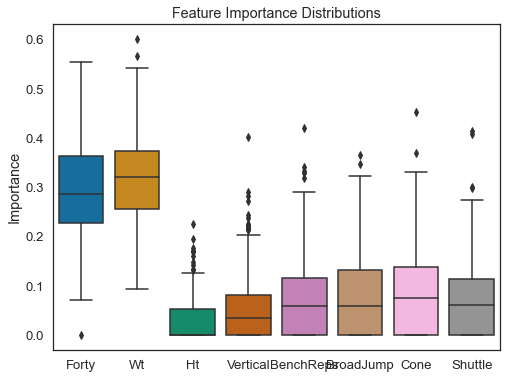

In [47]:
# tree.feature_importances_ is from scikit learn, so these are MDI importances 

# get the feature importances from each individual tree and then visualize the distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     estimator],
                               columns=features)

sns.boxplot(data=all_feat_imp_df).set(title='Feature Importance Distributions',
             ylabel='Importance')


As you can see, Forty and Weight are the most important features.

### C. Mean Decrease Accuracy/Permutation Importance

From the [scikit-learn docs](https://scikit-learn.org/stable/modules/permutation_importance.html): <br>

"The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature."

Let's use [this tutorial from kaggle](https://www.kaggle.com/dansbecker/permutation-importance) and the scikit-learn docs to break down the above definition. <br>

In permutation importance, all we do is scramble one feature, so that the relationship between the instance label and the feature value is random, as seen in the image below. <br>

![A table of features, where one column is being scrambled](img/permutation.png)

If a feature is important, when we scramble it and lose the relationship that gives the feature its predictive power, we will see a greater *decrease in accuracy*, thus the name Mean Decrease Accuracy (MDA). The greater the loss in performance upon permuting a given feature, the more important that feature is. Since there is randomness in the exact performance change of a model upon shuffling, we repeat the process multiple times on each feature with different shuffles, allowing us to measure the stochastity in our calculation. Strictly speaking, we would expect the MDA for a given feature not to be less than 0, because you wouldn't expect model performance to increase upon permuting a feature. However, negative values are occasionally obtained, and just means that the feature is not very important, and the random shuffling of the data actually *improved* the model performance. <br>

One of the great benefits of MDA is that it is *model agnostic*, meaning that it can be applied to models other than decision trees, including difficult-to-interpret black box models. Additionally, it is not biased towards continuous (numerical) features. However, it still gives high importance to features that allow overfitting, even if those features do not contribute to good predictions on unseen data. 

Additionally, we have to take into account strongly correlated features. Since we permute one feature at a time, if we permute a feature that is highly correlated to another, the model will still be able to make predictions without a large decrease in performance. This is because through the correlation, the model still has access to the feature we've permuted, and results in a lower score for both features, even if they may be important. 

**One more important thing emphasized by the sciki-learn docs:** <br>

"Note that features that are deemed non-important for some model with a low predictive performance could be highly predictive for a model that generalizes better. The conclusions should always be drawn in the context of the specific model under inspection and cannot be automatically generalized to the intrinsic predictive value of the features by themselves. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances." <br>

AKA, make sure your model isn't overfit before calculating feature importances!



We can use the package `eli5` to calculate permutation importance.

In [51]:
import eli5
from eli5.sklearn import PermutationImportance
# we need to impute the data first before calculating permutation importance
train_X_imp = imputer.transform(X)

# set up the met-estimator to calculate permutation importance on our training data
perm_train = PermutationImportance(estimator, scoring=r2,
                                   n_iter=50, random_state=RANDOM_STATE)
# fit and see the permuation importances
perm_train.fit(train_X_imp, y)
eli5.explain_weights_df(perm_train, feature_names=features)

,feature,weight,std
0,Wt,0.303350,0.032250
1,Forty,0.237577,0.031657
2,Cone,0.040714,0.005697
3,Shuttle,0.036012,0.005826
4,BroadJump,0.032836,0.005403
5,BenchReps,0.029503,0.004742
6,Vertical,0.022869,0.003648
7,Ht,0.009884,0.001659


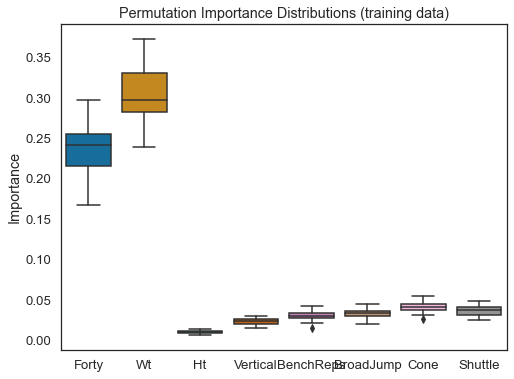

In [52]:
# plot the distributions
perm_train_feat_imp_df = pd.DataFrame(data=perm_train.results_,
                                      columns=features)
(sns.boxplot(data=perm_train_feat_imp_df)
        .set(title='Permutation Importance Distributions (training data)',
             ylabel='Importance'));

### D. Pros and Cons

We've already discussed some of the pros and cons of each method, but now let's take a look at the two methods side by side. 

| Attribute | Mean Decrease Impurity| Mean Decrease Accuracy (Permutation Importance) |
|:------:|:------:|:------:|
|Model agnostic?|N|Y|
|Biased towards continous features?|Y|N|
|Speed/convenience?|Calculated on-the-go|Need to retrain model for each permutation|
|Susceptible to correlated features?|[?](https://www.sciencedirect.com/science/article/pii/S0167947307003076?casa_token=3vWzXmNdC0MAAAAA:6Ugu68jnWcU_yZgRMXCyceRNHMDQA3HE2PHKflheLrciLIBZykiYEZNjAwa0GdczMGket24vCfg)|Y|

As you can see, the main advantage of Gini importance is that it's quick to calculate. However, if you need accurate feature importances for a set of features that are of mixed type, permutation importance is the way to go, even though it takes more time.

In [ ]:
## TODO double check the information in this table

In this section, we've talked about feature importances, whose values indicate how important a given feature is for the model's performance. However, it's not necessarily intuitive basedon feature importances alone, how our model made its decisions or predictions. In order to have a better idea about how specific predictions were made, we'll use something called *feature contributions*.

## 3. Evaluate Feature Contributions

In this section you will learn about: <br>
A. The mathematics of calculating feature contributions (The mathematics of feature contributions)<br>
B. The intuitive explanation of feature contributions (So what does this actually mean?)<br>
C. How to analyze feature contributions (Analyzing feature contributions)<br>

### A. The mathematics of feature contributions

This section is adapted from [this paper](https://arxiv.org/pdf/1312.1121.pdf) on feature contributions, and will take a decently deep dive into the math behind the Random Forest tree growing and decision process as well as that of calculating feature contributions. If you want to skip the math but get the general idea of what's going on, skip to the section: **B. So what does this actually mean?** <br> 

#### Understanding classification models

In order to understand feature contributions, we first have to understand how Random Forest works. The first part of this section is dedicated to understanding this process for classification models. <br>

In section 2, we went over how classification and regression trees (CART) work, and briefly mentioned how they are combined together in an ensemble to make a Random Forest. But what is actually happening? In short, during training/tree building, each decision tree in the forest only has access to a random subset of the data, and only a random subset of the features. In order to make a prediction, the individual trees all make a decision, and the final classification is decided upon by a vote. In essence, a bunch of crappy trees making a collective decision has better performance than one really good tree. If you are interested in a probabalistic mathematical explanation of how this works, please see the section **Probabalistic Interpretation of Classification Random Forest Models** in the supplemental.<br>

Now let's talk briefly about the proecss of *growing* a decision tree. In a Random Forest, each tree has access to only a random subset of the training data and a random subset of features. Once that training set is selected, a feature is used to split the data. The instances that arrive at a particular node after being split at a parent node are called *training instances*. This process is repeated iteratively until Gini impurity at the latest node is 0 (all instances at the node are of the same class), or further splitting doesn't improve the classification. 

**NOTE TO SELF:** *if there are only two classes, won't one of them always have a probability of more than 0.5 at any node in the tree? If so, how is any terminal node used to classify C2? "We will refer to instances of the local training set that pass through a given node as the training instances in this node. The fraction of the training instances in a node n belonging to class C1 will be denoted by Ynmean. This is the probability that a randomly selected element from the training instances in this node is in the first class. In particular, a terminal node is assigned to class C1 if Ynmean > 0.5 or Ynmean = 0.5 and the draw is resolved in favor of class C1."* <br> 

*Is this just what happens at terminal nodes where further splitting won't improve prediction? How does the algorithm know that further splitting won't improve the prediction? * <-- taking this as the ans

In [ ]:
## TODO make sure the above is correct and if not, change the explanation below 

If the Gini impurity of a node is 0, then we classify all instances arriving at that node according to whatever class all of those training instances at the terminal node belong to. But what happens if Gini impurity isn't 0, and further splitting doesn't improve the classification? 

At a given node $n$, the fraction of training instances belonging to class $C_{1}$ is denoted by $Y^{n}_{mean}$. This represents the probability that a randomly selected training instance at that node is of class $C_{1}$. If we've come to a terminal node that is impure, where further splitting won't improve our classification, this value is used to determine how that terminal node will classify any instances that arrive there by following the tree. If $Y^{n}_{mean} > 0.5$, that node will classify instanceas as $C_{1}$, or if $Y^{n}_{mean} == 0.5$ (a draw, since there are only two classes) and the draw is resolved (randomly) in favor of $C_{1}$. 

Great! Now that we know how trees are built and how instances are classified, let's talk about feature contributions.

#### Feature Contributions: Classification

In order to determine the feature contribution for a given instance predicted by a Random Forest, we have to follow two steps. First, we have to look at local feature contributions for each individual tree, and then second, aggregate them over the Forest. <br> 

Local contributions are determined using the following. First, we calculate the local increment for a 

$$ LI^{c}_{f} =   \left\{
\begin{array}{ll}
      Y^{c}_{mean} - Y^{p}_{mean} & \textrm{if the split in the parent
is performed over the
feature f} \\
      0 & \textrm{otherwise} \\
\end{array} 
\right. $$

where $LI^{c}_{f}$ is the local increment of feature $f$ at node $c$. A local increment can be intuitively thought of as the contribution a feature makes at a node towards correctly classifying an instance. In fact, if we look at the $Y_{mean}$ of the root of the tree, and the $Y_{mean}$ of a terminal node for an instance that ends up at that terminal node, we can see that the sum of the local increments for all nodes along that path is equal to the difference between the two $Y_{mean}$s -- which shows that those increments are directly responsible for the classification at the end of the tree. <br> 

For a given feature $f$, we can now calculate that feature's contribution to the prediction of a given instance $i$, by summing the $LI_{f}$ over the whole decision path for $i$:

$$FC^{f}_{i,t} = \sum\limits_{s = 0}^S LI_{f}$$

where $FC^{f}_{i,t}$ is the contribution of feature $f$ to predicting istance $i$ in a given tree $t$, and $S$ is the number of splits in the decision path. 

Now that we have our local contributions in individual trees, we have to aggregate them over the Forest. This is done using the following formula: 

$$FC^{f}_{i} = \frac{1}{T} \sum\limits_{t=1}^T FC^{f}_{i,t}$$

where $FC^{f}_{i}$ is the feature contribution of feature $f$ over the whole Forest to predicting instance $i$, and $T$ is the number of trees in the forest. We can then make a feature contributions vector for instance $i$, which is just a vector of $FC^{f}_{i}$ for all features used in the model. 

The last thing we need to mention here is something called the *unanimity condition*. This is when all terminal nodes in a tree or Forest are pure -- all training instances that have arrived to a given terminal node are of the same class. When this condition holds, we can use the feature contributions to recover the predictions in the model. Since this is only relevant to classification models, and in this tutorial we're dealing with a regression problem, further explanation can be found in the Supplemental, in the section **The Unanimity Condition: Using feature contributions to retrieve model predictions**.

#### Feature Contributions: Regressions

Now that's great, you're thinking, but what about regression trees? The method for computing feature contributions for a regression tree or Random Forest regression is analagous to that of a classification, with some slight differences. This section is adapted from the description found in [this blog post](http://blog.datadive.net/interpreting-random-forests/), which the module `treeinterpreter` is based on.<br>

The main difference is that for a regression, $Y^{n}_{mean}$, rather than being the fraction of training instances belonging to a given class, is just the mean of the training instances at a given node. For example, if a node has instances with the labels $(3,4,6,7)$, then the $Y^{n}_{mean}$ for that node is $5$. <br>

Therefore, the process is exactly the same as for classifications -- except that $LI^{c}_{f}$ represents the difference in mean of the training samples at two nodes, rather than the difference in probability of correct classification at a node. <br>

This also means we can use feature contributions to directly recover the predictions made by the model, since the feature contributions along a given decision path represent the change in mean (what we can think of as our prediction, since the mean at the terminal node is the prediction) from the previous to the current node. The equation that represents this is as follows: 

$$f(x) = c_{full} + \sum\limits^{K}_{k=1} contrib(x,k)$$

where $f(x)$ is our prediction, $c_{full}$ is the mean of all training instances at the root node, and $contrib(x,k)$ is the contribution of feature $k$ to the prediction of instance $x$. If we were to do this for a whole forest, we would simply be using the mean of the means at all root nodes, and the average contributions of features across the forest.

### B. So what does this actually mean?

Let's put this all together. We can represent the process of calculating feature contributions with the following schematic: 

![visual representation of feature contribution calculation](img/featureContributions.png)

For an instance $i$, we follow its decision path through the tree and calculate local increments at each node on the path. If the feature of interest, $f$, splits the node, the node receives a local increment that is greater than 1, the calculation of which can be found in the previous section. If the node is split over some other feature, the local increment is 0. We then sum up these local increments for the entire decision path, which gives us the feature contribution for this tree. We do this for every tree in the Forest, and then average the feature contributions, in order to get the overall feature contribution to the prediction made by the Forest.

This general schematic holds for both regressions and classification problems, the only difference is the way of calculating the local increment at each node. 

### C. Analyzing feature contributions

In [ ]:
## TODO